In [103]:
import sys
import os
from importlib import reload

module_path = os.path.abspath(os.path.dirname("./scripts/small_utilities.py"))
sys.path.insert(1, module_path)
from scripts.small_utilities import *

import numpy as np
import matplotlib.pyplot as plt
import mdtraj as md

plt.rc('font', family='Helvetica')

## Let's create some functions which will be helpful for our analysis

In [104]:
# Compute Radius of Gyration

def calc_rg(trj):

    """
    Compute Radius of gyration for the protein.
    
    Parameters:
    trj : mdtraj.Trajectory
        The trajectory containing the protein atoms.
        
    Returns:
    np.ndarray
        Time series of the radius of gyration.
    """

    mass = []
    for at in trj.topology.atoms:
        mass.append(at.element.mass)
    mass_CA = len(mass)*[0.0]
    # put the CA entries equal to 1.0
    for i in trj.topology.select("name CA"):
        mass_CA[i] = 1.0
    # calculate CA radius of gyration
    rg_CA = md.compute_rg(trj, masses=np.array(mass_CA))
    
    return rg_CA

def contact_map_protein_rw(trj, cutoff:float=0.6):
    
    """
    Compute a reweighted contact map and distance matrix for protein-protein interactions.
    
    Parameters:
    trj : mdtraj.Trajectory
        The trajectory containing the protein atoms.
    cutoff : float
        Distance cutoff for contact definition in nm.
        
    Returns:
    np.ndarray
        Contact map.
    """
    # Determine the number of residues
    p_residues = trj.topology.n_residues

    # Generate upper triangle indices for residue pairs
    indices = np.stack(np.triu_indices(p_residues, 1), axis=1)

    # Compute distances between residue pairs across all frames
    dist_array = np.array(md.compute_contacts(trj, indices)[0]).astype(float)

    # Identify contacts based on cutoff
    contact_array = np.where(dist_array < cutoff, 1, 0)

    # Initialize contact and distance matrices
    distance_matrix = np.zeros((p_residues, p_residues))
    contact_matrix = np.zeros((p_residues, p_residues))

    # Compute mean values without reweighting
    distance_matrix[indices[:, 0], indices[:, 1]] = dist_array.mean(axis=0)
    contact_matrix[indices[:, 0], indices[:, 1]] = contact_array.mean(axis=0)

    # Make matrices symmetric
    distance_matrix += distance_matrix.T
    contact_matrix += contact_matrix.T

    return np.array(contact_matrix).astype(float)  # , np.array(distance_matrix).astype(float)

def dssp_convert(dssp):


    dsspH = np.copy(dssp)
    dsspE = np.copy(dssp)
    dsspH[dsspH == 'H'] = 1
    dsspH[dsspH == 'E'] = 0
    dsspH[dsspH == 'C'] = 0
    dsspH[dsspH == 'NA'] = 0
    dsspH = dsspH.astype(int)
    SE_H = np.zeros((len(dssp[0]), 2))

    for i in range(0, len(dssp[0])):
        data = dsspH[:, i].astype(float)
        if(np.mean(data) > 0):
            SE_H[i] = [np.mean(data), (block(x=data))**.5]

    dsspE[dsspE == 'H'] = 0
    dsspE[dsspE == 'E'] = 1
    dsspE[dsspE == 'C'] = 0
    dsspE[dsspE == 'NA'] = 0
    dsspE = dsspE.astype(int)
    SE_E = np.zeros((len(dssp[0]), 2))

    for i in range(0, len(dssp[0])):
        data = dsspE[:, i].astype(float)
        if(np.mean(data) > 0):
            SE_E[i] = [np.mean(data), (block(x=data))**.5]
    return SE_H, SE_E

def ss(trj):

    import mdtraj as md

    dssp=md.compute_dssp(trj, simplified=True)
    H1_H,H1_E=dssp_convert(dssp)
    
    return H1_H, H1_E

def _plot_cm_all_1d(input:dict, cbar_label:str, file_name:str=None, save_fig:bool = False, show_fig:bool = False, title_dict:dict = None, offset=None,
                plot_args:dict = {'vmin': 0.0, 'vmax': 0.5, 'fig_size': (30,14), 'cax_coor': [0.93, 0.2, 0.02, 0.6], 'cmap': 'jet', 'aspect' : 'auto', 'rotation' : {'x' : 90, 'y' :0},
                                  'tick_size' : {'x' : 18, 'y' : 18, 'cax' :25}, 'label_size' : {'x' : 30, 'y' : 30, 'cax' :30}, 'title_size' :20, 'dpi' : 310, 'labels' : {'x' :"Residues", 'y':"Residues" },
                                  'nrows' : 2, 'ncols' : 5, 'xticks' : None, 'yticks' : None, 'tick_interval' : 2}):
        import matplotlib.pyplot as plt

        fig, axes = plt.subplots(plot_args['nrows'],plot_args['ncols'], figsize=plot_args['fig_size'], sharex=True, sharey=True, dpi=610)
        if plot_args['cax_coor'] : cax= fig.add_axes(plot_args['cax_coor'])
        else : cax = fig.add_axes([axes[plot_args['nrows']-1,plot_args['ncols']-1].get_position().x1+0.02,axes[1,2].get_position().y0,0.02,axes[0,0].get_position().y1-axes[plot_args['nrows']-1,plot_args['ncols']-1].get_position().y0])

        images=[]
        p=0
        for i in input.keys():
            
            im = axes[p].imshow(np.array(input[i]), vmin=plot_args['vmin'], vmax=plot_args['vmax'],cmap=plot_args['cmap'], aspect=plot_args['aspect'])
            im.axes.tick_params(axis='both',which='both',direction='out')
            axes[p].invert_yaxis()
            axes[p].set_xticks(range(0, len(plot_args['xticks'])+(offset-1),plot_args['tick_interval']), plot_args['xticks'][::plot_args['tick_interval']], rotation=plot_args['rotation']['x'], size=plot_args['tick_size']['x'])
            axes[p].set_yticks(range(0, len(plot_args['yticks'])+(offset-1),plot_args['tick_interval']), plot_args['xticks'][::plot_args['tick_interval']], rotation=plot_args['rotation']['y'], size=plot_args['tick_size']['y'])
            axes[p].grid(False)
            axes[p].set_title(f"{title_dict[p]}",size=plot_args['title_size'], pad=10)

            images.append(im)
            p=p+1
            
        cbar = fig.colorbar(images[-1],cax=cax)
        cbar.set_label(cbar_label, size=plot_args['label_size']['cax'], labelpad=10)
        cbar.ax.tick_params(labelsize=plot_args['tick_size']['cax'])

        fig.text(0.5, -0.12, plot_args['labels']['x'], ha="center", fontsize=plot_args['label_size']['x'])
        fig.text(0.005, 0.5, plot_args['labels']['y'], va="center", rotation="vertical", fontsize=plot_args['label_size']['y'])

        if show_fig : plt.show()

        if save_fig : assert file_name ; out_f = f"{file_name}" ; print(f'saving figure {file_name}!');plt.savefig(out_f, dpi=plot_args['dpi'],bbox_inches='tight')
        else : pass


def plot_phi_psi_contour(data, title='Ser129', xlabel=r'$\phi^{o}$', ylabel=r'$\psi^{o}$', figsize=(8, 7), cmap='bone', alpha_contour=0.3, alpha_scatter=0.6, alpha_contour_line=1, levels=[10**i for i in range(-7, 0)],
                         labelsize=28, fontsize=37, titlesize=30, scatter_size=5,  scatter_color='black', scatter=True, contour_fill=True, contour_line=True, contour_lw=1):
    import numpy as np
    from scipy.stats import gaussian_kde
    import matplotlib.pyplot as plt
    import matplotlib.colors as mplcolors
    import math

    x = np.array([math.degrees(i) for i in np.array(data).T[0]])
    y = np.array([math.degrees(i) for i in np.array(data).T[1]])

    x_grid, y_grid = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
    positions = np.vstack([x_grid.ravel(), y_grid.ravel()])
    values = np.vstack([x, y])
    kernel = gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, x_grid.shape)

    # Normalize
    Z_norm = np.log10(np.rot90(Z))

    fig, ax = plt.subplots(1, 1, figsize=figsize)

    pdata = np.rot90(np.fliplr(Z))

    if contour_fill : 
        ax.contourf(
            x_grid,
            y_grid,
            pdata.T,
            levels=levels,
            antialiased=True,
            extent=[-180, 180, -180, 180],
            alpha=alpha_contour,
            cmap=cmap,
        )

    if contour_line : 
        ax.contour(
            x_grid,
            y_grid,
            pdata.T,
            colors="k",
            levels=levels,
            antialiased=True,
            extent=[-180, 180, -180, 180],
            alpha=alpha_contour_line,
            linewidths=contour_lw,
        )

    if scatter : ax.scatter(x, y, s=scatter_size, color=scatter_color, alpha=alpha_scatter)

    ax.axhline(0, color='black', lw=2, ls='--')
    ax.axvline(0, color='black', lw=2, ls='--')

    ax.tick_params(axis='both', which='major', labelsize=labelsize)

    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    ax.set_xlim(-180, 180)
    ax.set_ylim(-180, 180)

    xticks_labels = [" "] + [i for i in np.arange(-180, 240, 60)[1:]]
    yticks_labels = np.arange(-180, 240, 60)
    ax.set_xticks(np.arange(-180, 240, 60), xticks_labels)
    ax.set_yticks(np.arange(-180, 240, 60), yticks_labels)

    ax.spines['top'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)

    ax.set_title(title, size=titlesize)

    plt.tight_layout()

## Loading the PBC corrected trajectories

In [ ]:
nrep=10
path_to_pdb = '../TUTORIAL_FILES/REST/prod.pdb' # this should be the pdb produced from running ./run_md.sh -s PBC or by hand with -pbc whole -center <-protein
rest_directory = '../TUTORIAL_FILES/REST/' 
path_to_xvg = './replica_index.n50.s0.-80.xvg' # Produced using the included perl script
xtc_name = 'whole' # This name corresponds to the naming of the pbc corrected trajectory inside each replica from REST

# Check if the files exists
for file_path in [path_to_pdb, path_to_xvg, rest_directory]+[f"{rest_directory}/{i}/{xtc_name}.xtc" for i in range(nrep)]:
    if not os.path.exists(file_path):
        print(f"{file_path} does not exist.")
        sys.exit(1)


p_sel = 'resid 0 to 19' # Protein residue selection


traj=[]
for i in range(nrep):
    # Load the trajectory
    traj.append(md.load(f"{rest_directory}/{i}/{xtc_name}.xtc", top=path_to_pdb))
    traj[i] = traj[i].atom_slice(traj[i].topology.select(p_sel))
    traj[i].center_coordinates()


In [56]:
nres = [res.resSeq for res in traj[0].topology.residues ]
sequence = [str(residue) for residue in traj[0].topology.residues]
res_name = [str(residue.name) for residue in traj[0].topology.residues]
resindex = [residue.index for residue in traj[0].topology.residues]

print("** SYSTEM INFO **\n")
print(f"Number of atoms: {traj[0].n_atoms}\n")
print(f"Number of residues: {traj[0].n_residues}\n")
print(f"Number of frames: {traj[0].n_frames}\n")
print(f"sequence: {sequence}\n")

ticks_pnum, ticks_pname = sequence_ticks_1(sequence)

residue_offset = 121
residue_number_offsetres = range(residue_offset, residue_offset+traj[0].n_residues)
print(f"Residue number range: {traj[0].topology.residue(0).index} to {traj[0].topology.residue(traj[0].n_residues-1).index}\n")

r2_temp = compute_temperatures((300, 450), 10)

print(f"Temperature range: {[f'{np.round(temp)} K' for temp in r2_temp]}")


** SYSTEM INFO **

Number of atoms: 294

Number of residues: 20

Number of frames: 12501

sequence: ['NASP121', 'ASN122', 'GLU123', 'ALA124', 'TYR125', 'GLU126', 'MET127', 'PRO128', 'SER129', 'GLU130', 'GLU131', 'GLY132', 'TYR133', 'GLN134', 'ASP135', 'TYR136', 'GLU137', 'PRO138', 'GLU139', 'CALA140']

Residue number range: 0 to 19

Temperature range: ['300.0 K', '314.0 K', '328.0 K', '343.0 K', '359.0 K', '376.0 K', '393.0 K', '411.0 K', '430.0 K', '450.0 K']


## Compute and plot Radius fo gyration

In [51]:
rg=[]
for i in range(nrep):
    rg.append(calc_rg(traj[i]))


## Generate the time series

In [52]:
time=[]
timestep=80 # ps

for i in range(len(rg[0])):  

    time.append((timestep*i)/10**6)

time=np.array(time)

time

array([0.0000e+00, 8.0000e-05, 1.6000e-04, ..., 9.9984e-01, 9.9992e-01,
       1.0000e+00])

## Time series of Rg which is window averaged for every 200 frames

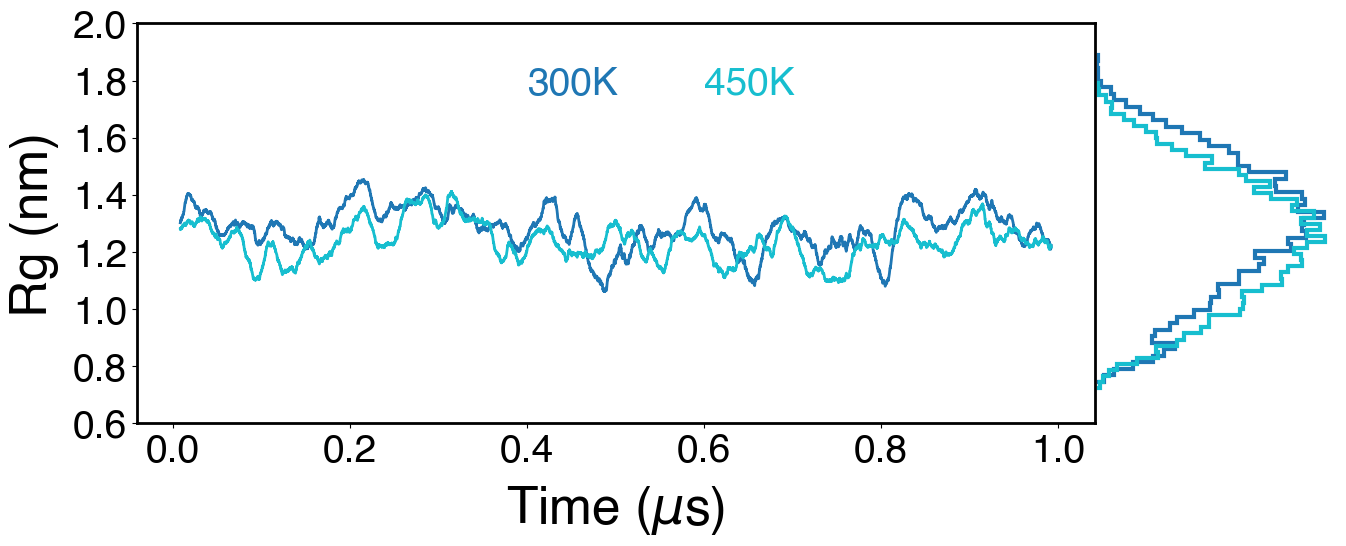

In [ ]:

for i in [200] :
    
        fig, ax = plt.subplots(1, 2, figsize=(15, 5),
                        gridspec_kw={'width_ratios':[4,1], 'height_ratios':[1], 'left':0.1, 'right':0.9,
                                        'bottom':0.1, 'top':0.9,'wspace':0.004, 'hspace':0.2},sharey=True)

        N=i

        ax[0].plot(np.convolve(time, np.ones(N)/N, mode='valid'),
                np.convolve(rg[0], np.ones(N)/N, mode='valid'),
                lw=2, color=plt.cm.tab10(0))
        ax[0].plot(np.convolve(time, np.ones(N)/N, mode='valid'),
                np.convolve(rg[9], np.ones(N)/N, mode='valid'),
                lw=2, color=plt.cm.tab10(9))

        ax[1].hist(rg[0], bins=50, density=True, orientation='horizontal', color=plt.cm.tab10(0), histtype='step', lw=3)
        ax[1].hist(rg[9], bins=50, density=True, orientation='horizontal', color=plt.cm.tab10(9), histtype='step', lw=3)

        ax[0].tick_params(axis='both', which='major', labelsize=28)

        ax[0].text(0.4, 1.75, f'{round(r2_temp[0])}K', size=28, color=plt.cm.tab10(0))
        ax[0].text(0.6, 1.75, f'{round(r2_temp[9])}K', size=28, color=plt.cm.tab10(9))

        ax[0].set_xlabel(r'Time ($\mu$s)', fontsize=37, labelpad=10)
        ax[0].set_ylabel('Rg (nm)', fontsize=37, labelpad=10)
        ax[0].set_xticks(np.arange(0, 1.2, 0.2),[round(i,1) for i in np.arange(0, 1.2, 0.2)])
        ax[0].set_yticks(np.arange(0.6, 2.2, 0.2),[round(i,1) for i in np.arange(0.6, 2.2, 0.2)])

        ax[0].spines['left'].set_linewidth(2)
        ax[0].spines['bottom'].set_linewidth(2)
        ax[0].spines['top'].set_linewidth(2)
        ax[0].spines['right'].set_linewidth(2)

        ax[1].tick_params(axis='both', which='major', labelsize=28)
        ax[1].set_xticks(np.arange(0, 2, 0.5),np.arange(0, 2, 0.5))
        ax[1].spines['top'].set_visible(False)
        ax[1].spines['right'].set_visible(False)
        ax[1].spines['left'].set_visible(False)
        ax[1].spines['bottom'].set_visible(False)
        ax[1].tick_params(axis='both', which='major', top=False, bottom=False, left=False, right=False,
                        labelleft=False, labelright=False, labeltop=False, labelbottom=False)
        ax[1].tick_params(axis='both', which='minor', top=False, bottom=False, left=False, right=False,
                        labelleft=False, labelright=False, labeltop=False, labelbottom=False)




## Mean Radius of gyration computed and plotted w.r.t respective replica temperature

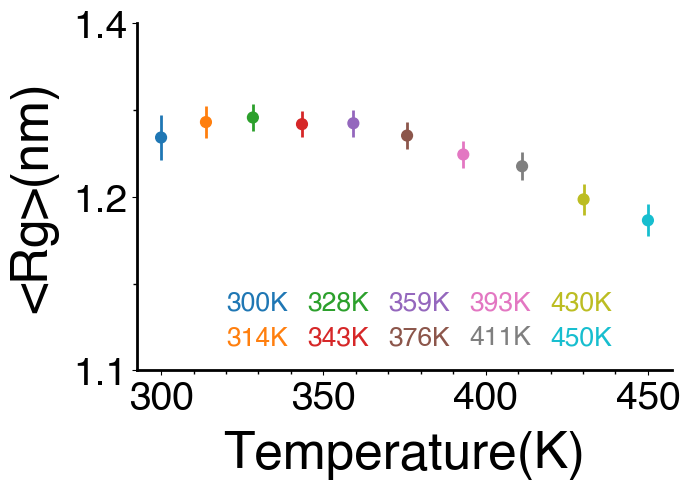

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))

ax.scatter(r2_temp,[get_blockerror_pyblock_nanskip_rw_(np.array(rg[i]))[0] for i in range(10)], s=60, c=[plt.cm.tab10(i) for i in range(10)])
ax.errorbar(r2_temp,[get_blockerror_pyblock_nanskip_rw_(np.array(rg[i]))[0] for i in range(10)], elinewidth=2, 
            yerr=[get_blockerror_pyblock_nanskip_rw_(np.array(rg[i]))[1] for i in range(10)], ecolor=[plt.cm.tab10(i) for i in range(10)], ls='none')

ax.tick_params(labelsize=28)
ax.set_yticks(np.arange(1.15,1.4,0.1),[f"{i:2.1f}" for i in np.arange(1.15,1.4,0.1)])
ax.set_xticks(np.arange(300,500,50), np.arange(300,500,50))
ax.set_xlabel("Temperature(K)", labelpad=10, size=37)
ax.set_ylabel("<Rg>(nm)", labelpad=10, size=37)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)

plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(50/5))
ax.tick_params(axis='x', which='minor', length=3, width=1, color='k', direction='out')
plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(0.1/2))
ax.tick_params(axis='y', which='minor', length=3, width=1, color='k', direction='out')

y=1.185
x=320
for i in range(len(r2_temp)):
        
    ax.text(x, y, f"{round(r2_temp[i])}K", size=19, color=plt.cm.tab10(i))
    y=y-0.02
    if i%2 : x = x+25 ; y=1.185
    
plt.tight_layout()


## Secondary structure propensity 

In [68]:
helix=[]
sheet=[]

for i in range(nrep):
    h, s = ss(traj[i])
    helix.append(h)
    sheet.append(s)


/Users/jayakrishnakoneru/Documents/GitHub/enhanced_sampling_tutorial/POST_SIMULATION_ANALYSIS/scripts/small_utilities.py:46: RuntimeWarning: invalid value encountered in divide
  M = (cumsum(((gamma/s)**2*2**arange(1, d+1)[::-1])[::-1]))[::-1]


<Figure size 1500x500 with 0 Axes>

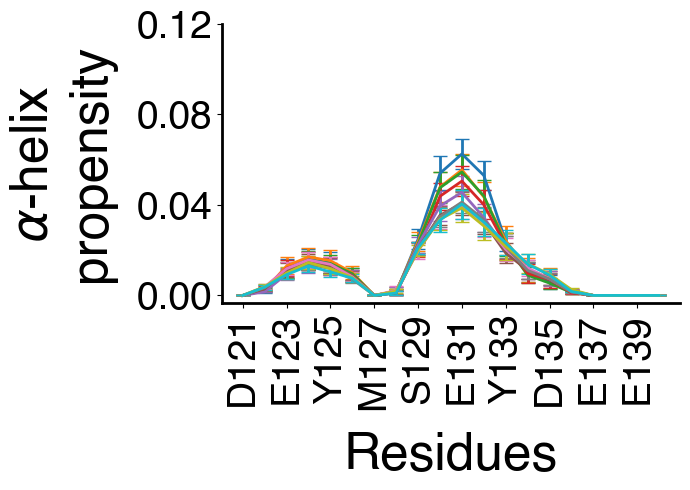

In [ ]:
plt.figure(figsize=(15,5))

fig, axes = plt.subplots(1,1, figsize=(7,5), sharex=True, sharey=True)

for i in range(len(helix)):
        
    axes.errorbar(ticks_pnum, np.array(helix[i]).T[0], yerr=np.array(helix[i]).T[1], color=plt.cm.tab10(i), lw=2, capsize=5)

axes.tick_params(labelsize=28)
axes.set_xlabel('Residues', size=37, labelpad=15)
axes.set_ylabel(r'$\alpha$-helix' + '\npropensity', size=37,labelpad=15)
axes.set_xticks(range(0,20,2), ticks_pnum[::2],rotation=90)
axes.set_yticks(np.arange(0,0.14,0.04))

axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.spines['left'].set_linewidth(2)
axes.spines['bottom'].set_linewidth(2)

plt.tight_layout()

## Inter-residue contacts of protein amino acids

In [ ]:
p_cm = []

for i in range(nrep):
    p_cm.append(contact_map_protein_rw(traj[i], cutoff=0.6))

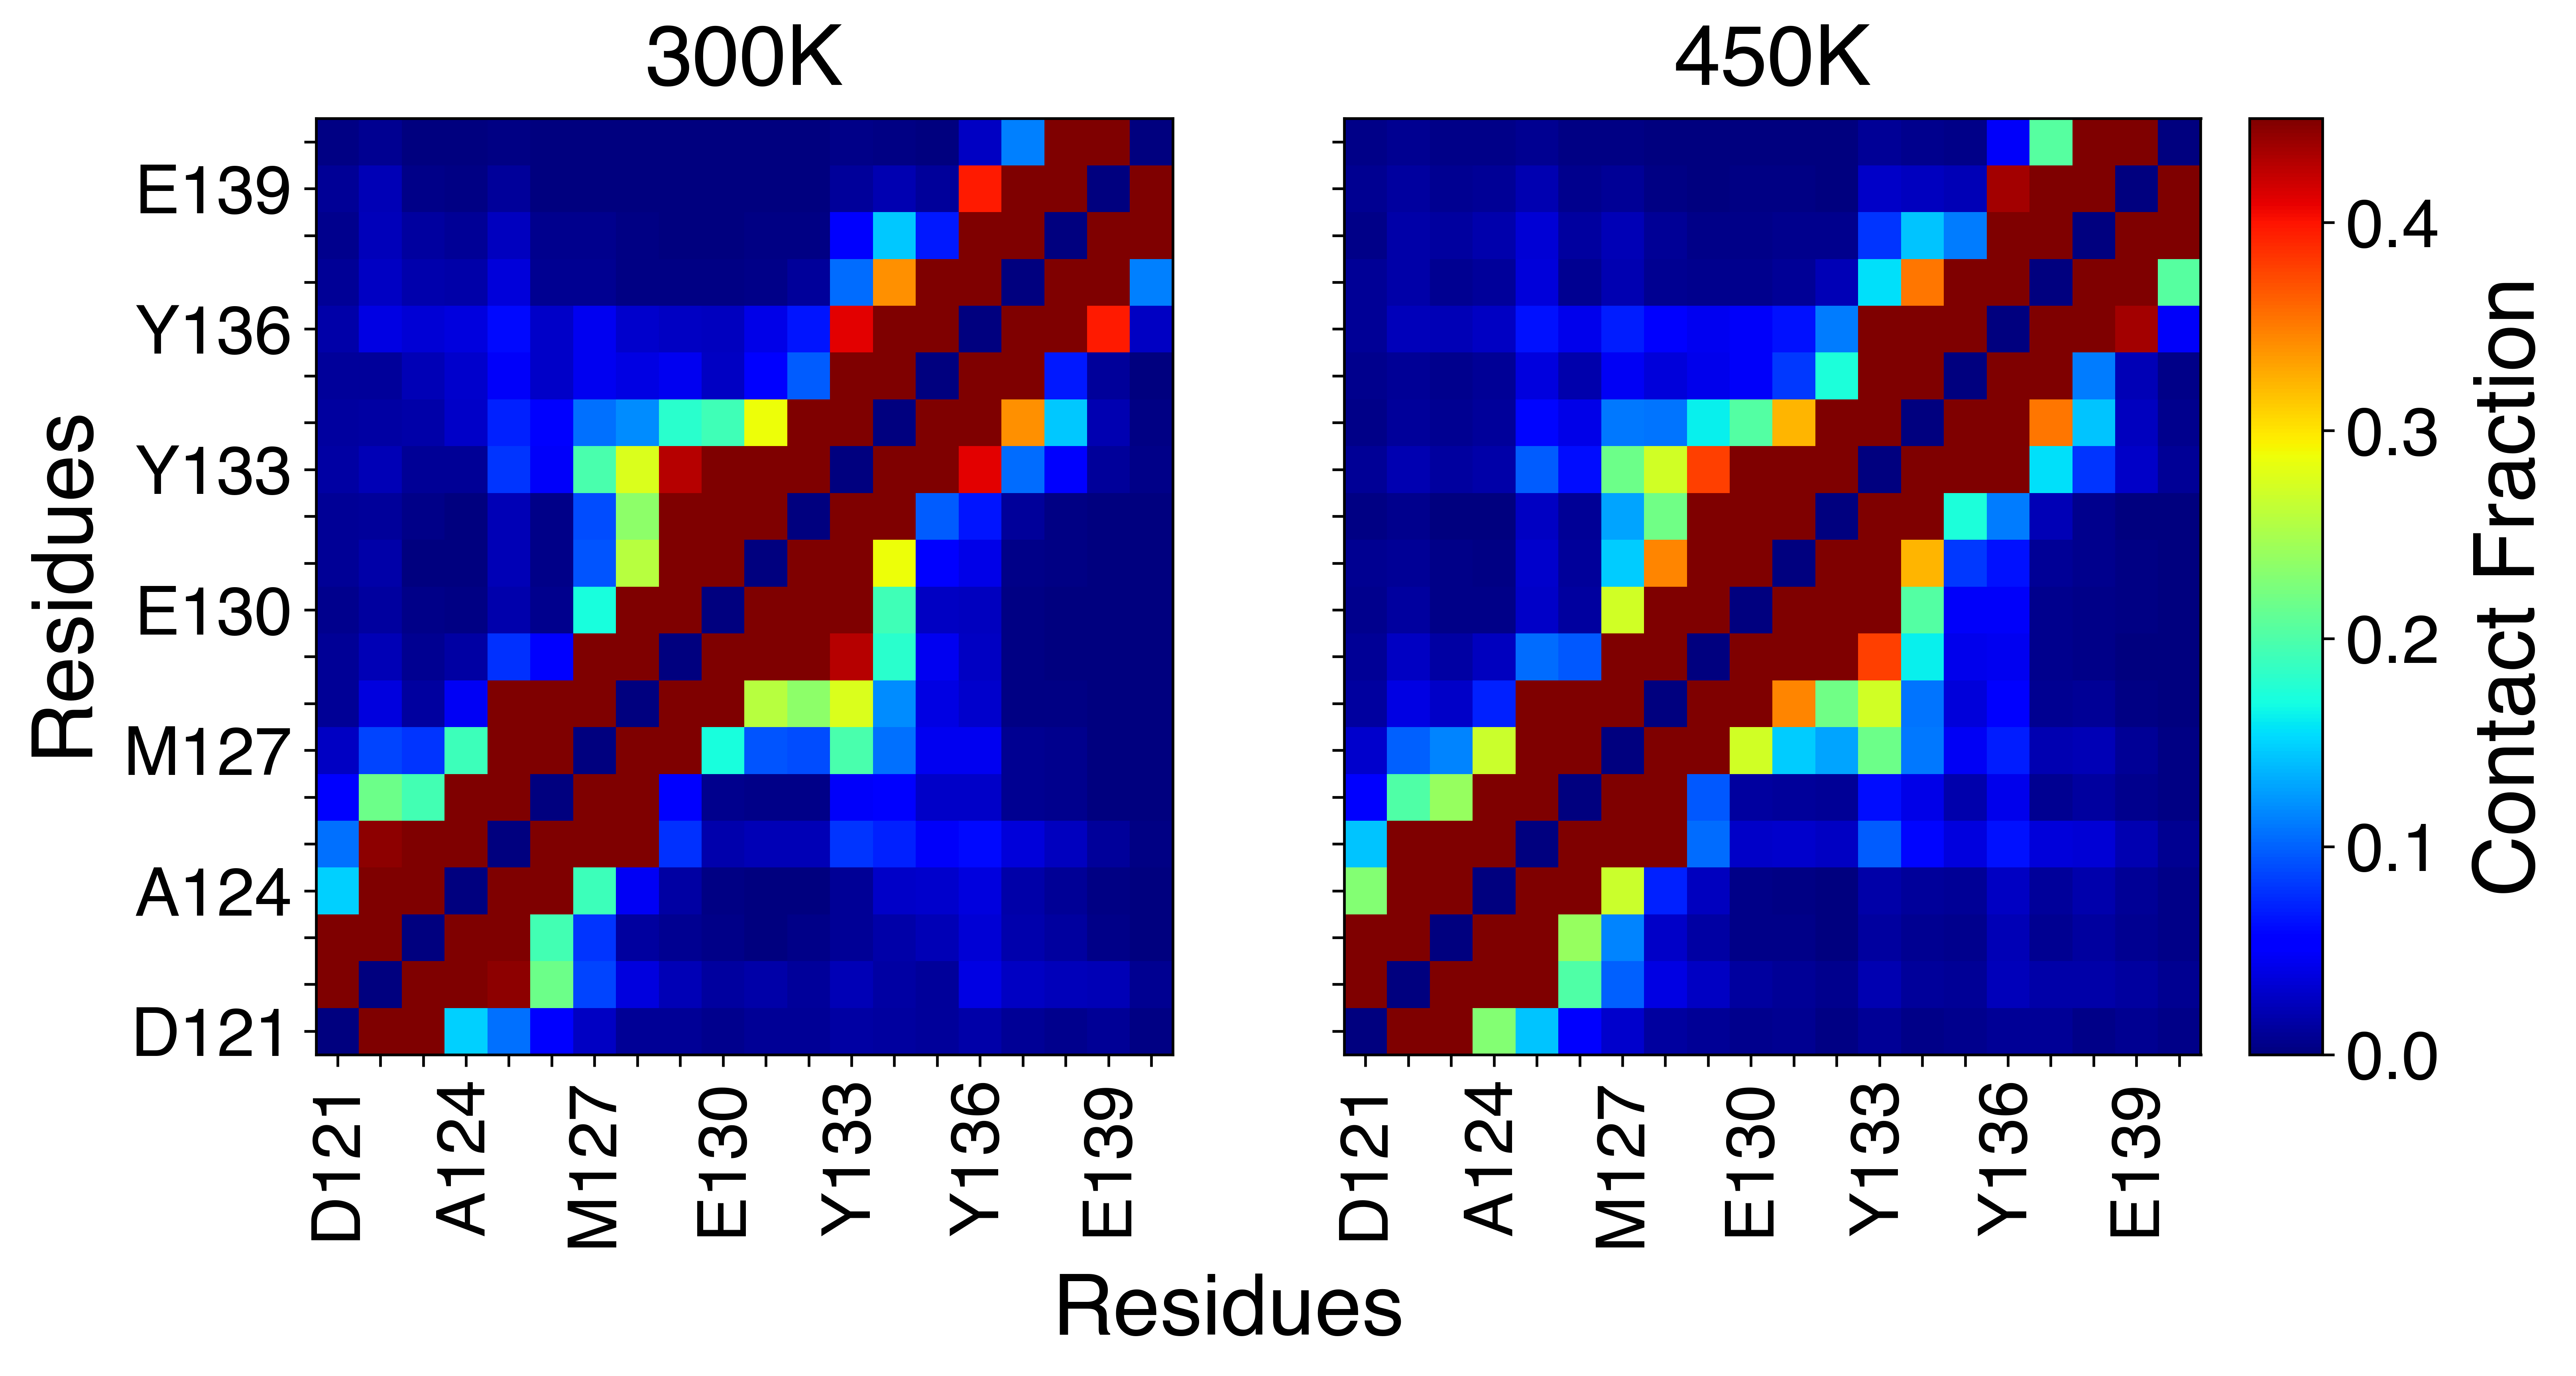

In [ ]:
plot_args={'vmin': 0.0,
           'vmax': 0.45,
           'fig_size': (10, 5),
           'cax_coor': [.92, .11, .03, .77],
           'cmap': 'jet',
           'aspect' : 'auto',
           'rotation' : {'x' : 90, 'y' :0},
           'tick_size' : {'x' : 20, 'y' : 20, 'cax' :20},
           'label_size' : {'x' : 25, 'y' : 25, 'cax' :25},
           'title_size' :25,
           'dpi' : 610,
           'labels' : {'x' :"Residues", 'y':"Residues" },
           'nrows' : 1, #5
           'ncols' : 2, #2
           'xticks' : [" "  if i%3 else ticks_pnum[i] for i in range(len(ticks_pname)) ],
           'yticks' : [" "  if i%3 else ticks_pnum[i] for i in range(len(ticks_pname)) ],
           'tick_interval' : 1}

in_dict={int(i):p_cm[i] for i in range(len(p_cm)) if i==0 or i==9}
_plot_cm_all_1d(in_dict, 'Contact Fraction', show_fig=True, title_dict=[f'{round(r2_temp[i])}K' for i in range(0,10,9)], offset=1, 
             plot_args=plot_args)

## Ramachandran plots for the center residues of the protein 

In [81]:
phi_psi_ser129 = [[118, 120, 122, 129], [120, 122, 129, 131]]
phi_psi_glu130 = [[129, 131, 133, 144], [131, 133, 144, 146]]
phi_psi_glu131 = [[144, 146, 148, 159], [146, 148, 159, 161]]

dihedrals_ser129 = []
for i in range(nrep):
    dihedrals_ser129.append(md.compute_dihedrals(traj[i], phi_psi_ser129))

dihedrals_glu130 = []
for i in range(nrep):
    dihedrals_glu130.append(md.compute_dihedrals(traj[i], phi_psi_glu130))

dihedrals_glu131 = []
for i in range(nrep):
    dihedrals_glu131.append(md.compute_dihedrals(traj[i], phi_psi_glu131))



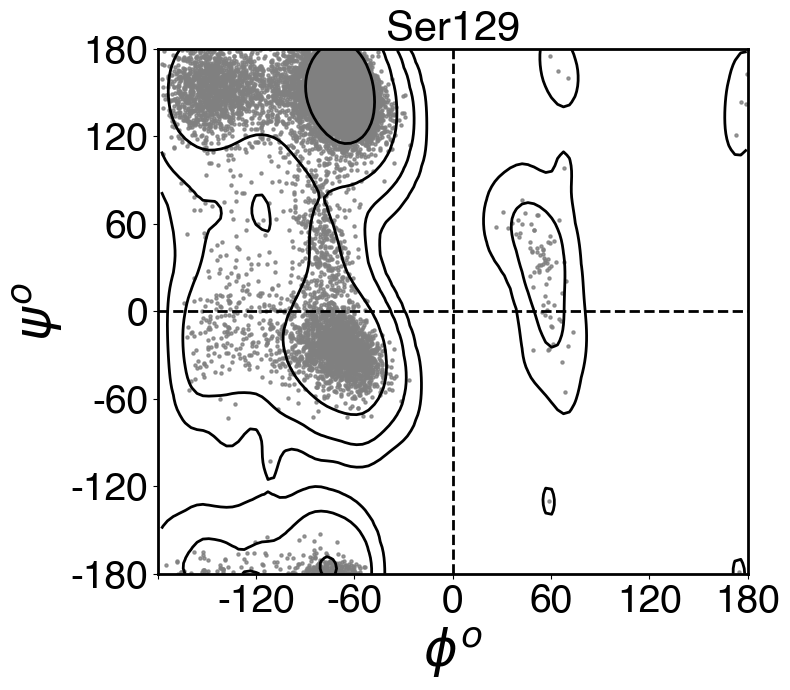

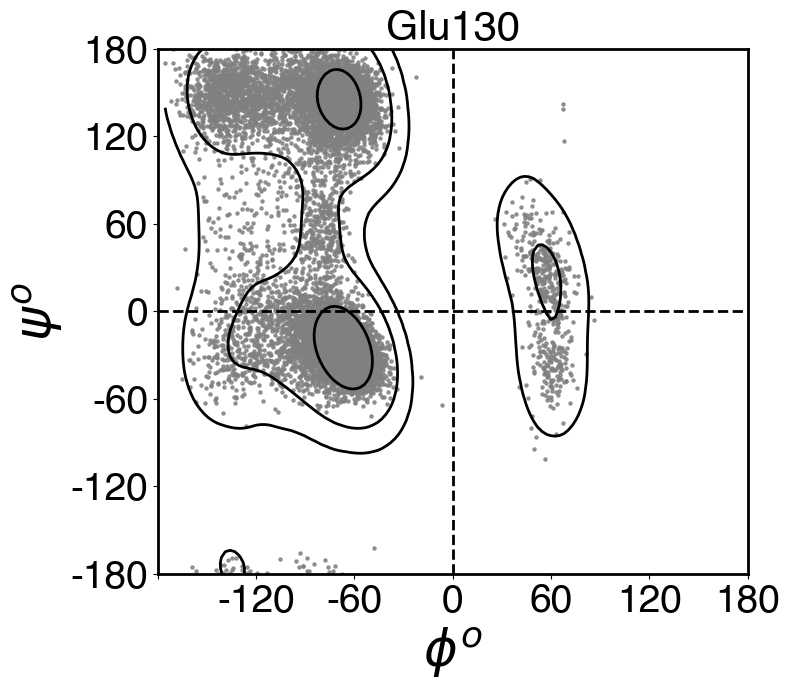

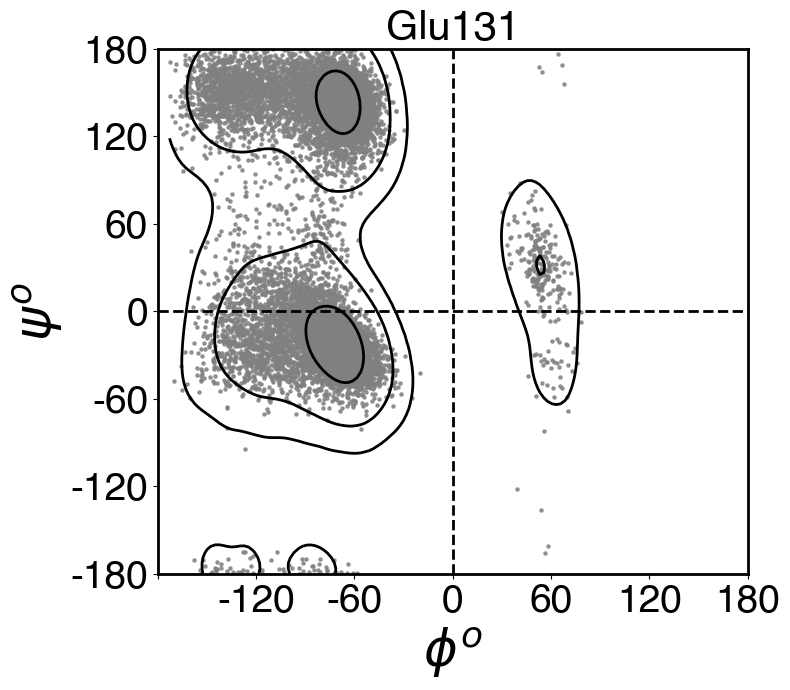

In [ ]:
plot_phi_psi_contour(dihedrals_ser129[0], levels=[10**i for i in range(-7,0)], title='Ser129', scatter=True, scatter_color='grey', alpha_scatter=0.8, contour_fill=False, contour_lw=2)
plot_phi_psi_contour(dihedrals_glu130[0], levels=[10**i for i in range(-6,0)], title='Glu130', scatter=True, scatter_color='grey', alpha_scatter=0.8, contour_fill=False, contour_lw=2)
plot_phi_psi_contour(dihedrals_glu131[0], levels=[10**i for i in range(-6,0)], title='Glu131', scatter=True, scatter_color='grey', alpha_scatter=0.8, contour_fill=False, contour_lw=2)

## Sanity check for the Replica exchnage analysis

In [ ]:
# Load the xvg files

file_path='./reference_files/'
xvg_files = [ 'replica_temp.xvg', 'replica_index.xvg']

xvg_temp=np.loadtxt(f'{file_path}/{xvg_files[0]}', comments=['#','@'])
xvg_index=np.loadtxt(f'{file_path}/{xvg_files[1]}', comments=['#','@'])

In [105]:
# Probabilities of replica visiting the base or zeroth replica
prob=[]
b=0
for i in range(nrep):
    a=(np.where(xvg_temp.T[0+1]==i)[0].shape[0])/(xvg_temp.shape[0])
    prob.append(a)
    print(i,a)
    b=b+a
print(f'Probability check : {b}')

0 0.1012464
1 0.1013104
2 0.1005744
3 0.0974288
4 0.0965744
5 0.0975024
6 0.099304
7 0.1002416
8 0.1018624
9 0.1039552
Probability check : 1.0


In [ ]:
# Mean effective temperature of each respective replica

T_mean=[]

for j in range(1,nrep+1):
    replica_T=[]
    for i in xvg_index.T[j]:
        replica_T.append(float(r2_temp[int(i)]))
    T_mean.append(np.mean(replica_T))

In [ ]:
# Compute Round Trip Times
def calc_round_trip_stack_2(file, nreps=20):
    
    n=0
    d=0
    rep_dict={}
    rep=[i for i in range(nreps)]
    data=np.loadtxt(file ,comments=["@", "#"])[:,1:]

    for i in rep:
        rep_dict[i] = 0
        stack = []
        for e in data.T[i]:
            n+=1
            if int(e) not in stack:
                stack.append(int(e))
            if e == nreps-1:
                d=1
            if e == 0 and d == 1:
                d=0
                rep_dict[i]+=1
                stack = []
                
    return rep_dict

In [ ]:
rt_dict=calc_round_trip_stack_2(f'{file_path}/{xvg_files[0]}',nreps=10)

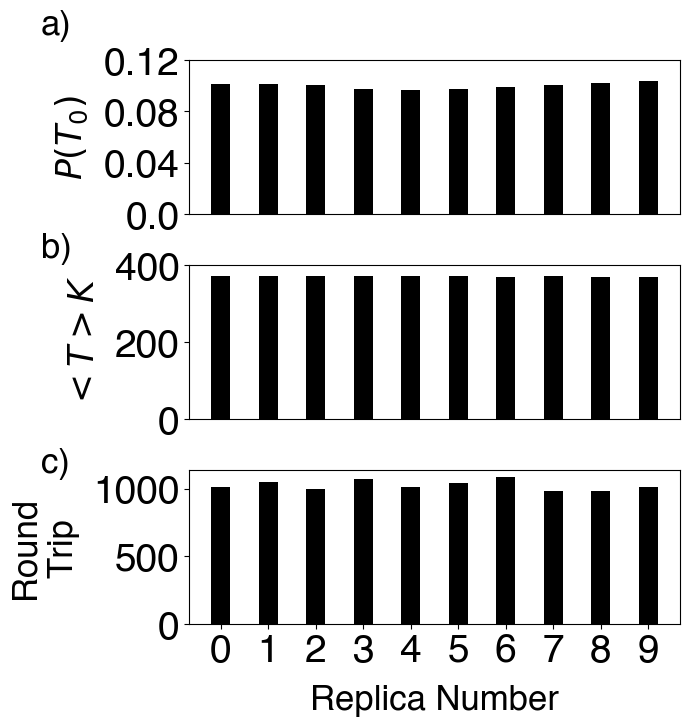

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(7,7), sharex=True)

ax[0].tick_params(axis='y', labelsize=28)
ax[0].bar(range(nrep),prob,width = 0.4, color='k')
ax[0].set_yticks(np.arange(0,0.16,0.04),np.arange(0,0.16,0.04))
ax[0].set_ylabel(r'$P(T_{0})$', size=25, labelpad=10)
ax[1].tick_params(axis='y', labelsize=28)
ax[1].bar(range(nrep),T_mean,width = 0.4, color='k')
ax[1].set_yticks(range(0,600,200),range(0,600,200))
ax[1].set_ylabel(r'$<T>K$', size=25, labelpad=10)

ax[0].tick_params(top=False, bottom=False,
                labeltop=False, labelbottom=False)
ax[1].tick_params(top=False, bottom=False,
                labeltop=False, labelbottom=False)
ax[2].tick_params(top=False, bottom=True,
                labeltop=False, labelbottom=True)
ax[2].tick_params(axis='x', labelsize=28)
ax[2].tick_params(axis='y', labelsize=28)
for keys in rt_dict.keys():
    ax[2].bar(keys,rt_dict[keys],width = 0.4, color='k')

ax[2].set_xticks(range(nrep),range(nrep))
ax[2].set_yticks(range(0,1500,500),range(0,1500,500))
ax[2].set_ylabel('Round\nTrip', size=25, labelpad=10)
ax[2].set_xlabel('Replica Number', size=25, labelpad=10)

plt.tight_layout()

sub_fig_labels=['a)', 'b)', 'c)']
y_pos = [0.14, 420, 1120]

for i in range(3):
    ax[i].text(-3.8, y_pos[i], sub_fig_labels[i], size=25)
